In [1]:
import numpy as np
import tensorflow as tf
import csv
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import ast
import json
import re
from google.colab import drive
import torch
import torch.nn as nn



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# # Load data from .npy file
data= np.load("/content/drive/MyDrive/SP-train.npy", allow_pickle=True)[()]

In [4]:
data[1:10]

array([{'id': 'SP-0_SR', 'question': 'The six daughters of Mr. and Mrs. Mustard each have one brother. However, the family only consists of nine people; how is that possible?', 'answer': 'Each daughter shares the same brother.', 'distractor1': 'Some daughters get married and have their own family.', 'distractor2': 'Some brothers were not loved by family and moved away.', 'distractor(unsure)': 'None of above.', 'label': 2, 'choice_list': ['Some brothers were not loved by family and moved away.', 'Some daughters get married and have their own family.', 'Each daughter shares the same brother.', 'None of above.'], 'choice_order': [2, 1, 0, 3]},
       {'id': 'SP-0_CR', 'question': 'A chess team has five players, and each player has one coach. But there are only six participants in the team. How is that possible?', 'answer': 'Each player shares the same coach.', 'distractor1': 'Some coaches get a raise.', 'distractor2': 'Some players are backups and not allowed to play.', 'distractor(unsure

In [5]:
df = pd.DataFrame(data)


In [6]:
# Create a Pandas DataFrame
df = pd.DataFrame(data)
df

,0
0,"{'id': 'SP-0', 'question': 'Mr. and Mrs. Musta..."
1,"{'id': 'SP-0_SR', 'question': 'The six daughte..."
2,"{'id': 'SP-0_CR', 'question': 'A chess team ha..."
3,"{'id': 'SP-1', 'question': 'A woman shoots her..."
4,"{'id': 'SP-1_SR', 'question': 'An individual s..."
...,...
502,"{'id': 'SP-207_SR', 'question': 'Ten pears hun..."
503,"{'id': 'SP-207_CR', 'question': 'There were tw..."
504,"{'id': 'SP-208', 'question': 'The more you tak..."
505,"{'id': 'SP-208_SR', 'question': 'The more you ..."


In [7]:
# Split data into training and validation
split_ratio = 0.8

total_samples = len(data)
split_index = int(total_samples * split_ratio)

training_data = data[:split_index]
validation_data = data[split_index:]

# Extract questions, options, and correct_indices for training and validation sets
questions = [entry['question'] for entry in training_data]
options = [entry['choice_list'] for entry in training_data]
correct_indices = [entry['label'] for entry in training_data]
answer = [entry['answer'] for entry in training_data]

validation_questions = [entry['question'] for entry in validation_data]
validation_options = [entry['choice_list'] for entry in validation_data]
validation_correct_indices = [entry['label'] for entry in validation_data]
validation_answer = [entry['answer'] for entry in validation_data]

In [8]:
answer

['Each daughter shares the same brother.',
 'Each daughter shares the same brother.',
 'Each player shares the same coach.',
 'The woman was a photographer. She shot a picture of her husband, developed it, and hung it up to dry.',
 'The woman was a photographer. She shot a picture of her husband, developed it, and hung it up to dry.',
 'The woman was a photographer.',
 'This man is bald.',
 'This man is bald.',
 'This man is bald.',
 'Give the fifth girl her apple in the basket.',
 'Give the fifth girl her apple in the basket.',
 'Hand over the final bean to the seventh sorcerer without removing it from the vase.',
 "Tom's mother slid a newspaper under a door, each sibling standing on each side.",
 "Tom's mother slid a newspaper under a door, each sibling standing on each side.",
 "The couple was standing on two sides of the girl's apartment door, which had a rug under it.",
 'The rope is not tied to anything else.',
 'The rope is not tied to anything else.',
 "The station wasn't fixed

In [9]:
len(correct_indices)

405

In [10]:
correct_indices

[1,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 3,
 3,
 3,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 2,
 3,
 3,
 3,
 0,
 0,
 0,
 3,
 3,
 3,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 3,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,


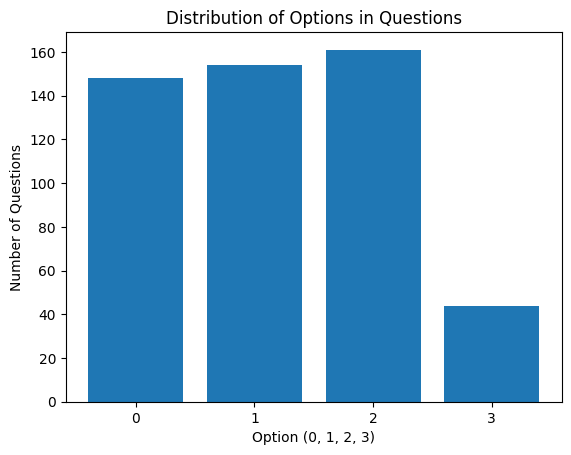

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
data11 = correct_indices + validation_correct_indices # Your sequence of options (0, 1, 2, 3)

# Create a DataFrame with the data
df11 = pd.DataFrame(data11, columns=['option'])

# Count the occurrences of each option (0, 1, 2, 3) in the dataset
option_counts = df11['option'].value_counts().sort_index()

# Create a bar graph
plt.bar(option_counts.index, option_counts.values)
plt.title('Distribution of Options in Questions')
plt.xlabel('Option (0, 1, 2, 3)')
plt.ylabel('Number of Questions')
plt.xticks(option_counts.index)  # Ensure all options are shown on the x-axis
plt.show()


Predicted Next Value: 1.087329192466957


IndexError: ignored

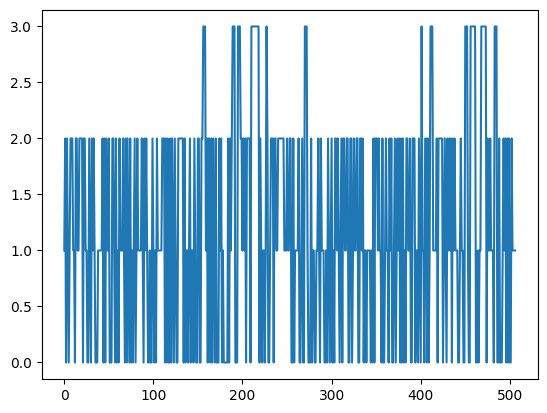

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Sample time series data (replace with your actual data)
data1_1= correct_indices +validation_correct_indices # Your sequence here

# Create a DataFrame with the data
df = pd.DataFrame(data1_1, columns=['value'])

# Define ARIMA model with adjusted order
model = ARIMA(df['value'], order=(1, 0, 1))  # Adjust the order as needed

# Predict the next value
forecast = model_fit.get_forecast(steps=1)
next_value = forecast.predicted_mean.values[0]

print("Predicted Next Value:", next_value)


# Plot the original data and predicted value
plt.plot(df['value'], label='Original Data')
plt.plot(len(df), next_value, 'ro', label='Predicted Value')
plt.legend()
plt.show()


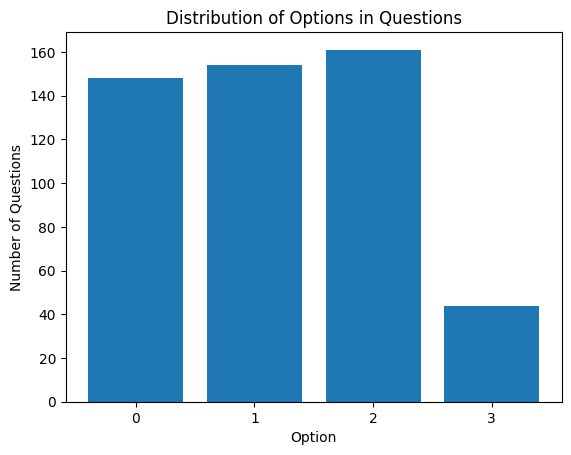

In [12]:
options = [0, 1, 2, 3]

# Create a bar graph with explicit labels
plt.bar(options, option_counts)
plt.title('Distribution of Options in Questions')
plt.xlabel('Option')
plt.ylabel('Number of Questions')
plt.xticks(options)  # Set explicit labels on the x-axis
plt.show()

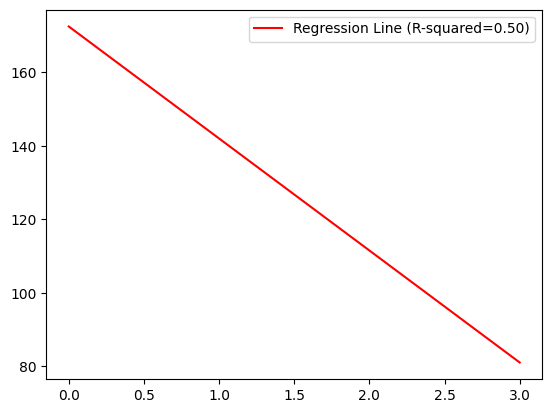

In [13]:
# Calculate and plot a linear regression line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(options, option_counts)
plt.plot(options, slope * np.array(options) + intercept, color='red', label=f'Regression Line (R-squared={r_value**2:.2f})')
plt.legend()

plt.show()

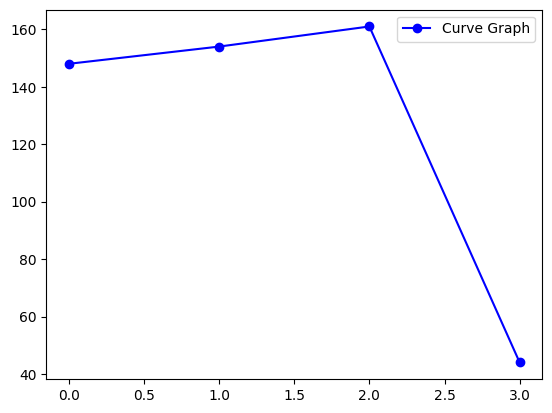

In [14]:
# Create a curve graph along x and y-axis
x = options
y = option_counts
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Curve Graph')

# Show legends for both bar and curve graphs
plt.legend()

plt.show()

In [15]:
from textblob import TextBlob
neu=0
pos=0
neg=0
for question in questions+ validation_questions:
    text = question
    blob = TextBlob(text)
    sentiment = blob.sentiment

    if sentiment.polarity > 0:
        sentiment_label = "positive"
        pos+=1
    elif sentiment.polarity < 0:
        sentiment_label = "negative"
        neg+=1
    else:
        sentiment_label = "neutral"
        neu+=1

    print(f"Sentiment: {sentiment_label}, Polarity: {sentiment.polarity}")
print(f"Positive: {pos}, Negative: {neg}, Neutral: {neu}")


Sentiment: neutral, Polarity: 0.0
Sentiment: neutral, Polarity: 0.0
Sentiment: neutral, Polarity: 0.0
Sentiment: positive, Polarity: 0.35
Sentiment: positive, Polarity: 0.1
Sentiment: positive, Polarity: 0.03749999999999999
Sentiment: negative, Polarity: -0.03214285714285715
Sentiment: positive, Polarity: 0.045238095238095244
Sentiment: positive, Polarity: 0.18333333333333335
Sentiment: neutral, Polarity: 0.0
Sentiment: neutral, Polarity: 0.0
Sentiment: positive, Polarity: 0.5
Sentiment: negative, Polarity: -0.10500000000000001
Sentiment: negative, Polarity: -0.041666666666666664
Sentiment: positive, Polarity: 0.05
Sentiment: positive, Polarity: 0.039999999999999994
Sentiment: negative, Polarity: -0.020000000000000007
Sentiment: neutral, Polarity: 0.0
Sentiment: neutral, Polarity: 0.0
Sentiment: neutral, Polarity: 0.0
Sentiment: neutral, Polarity: 0.0
Sentiment: neutral, Polarity: 0.0
Sentiment: positive, Polarity: 0.03333333333333333
Sentiment: positive, Polarity: 0.08333333333333333


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Sample data
texts = questions + validation_questions
labels = correct_indices + validation_correct_indices

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a classifier (Multinomial Naive Bayes in this case)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predict labels for the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.3137254901960784
              precision    recall  f1-score   support

           0       0.25      0.12      0.16        34
           1       0.32      0.46      0.38        28
           2       0.33      0.52      0.41        29
           3       0.00      0.00      0.00        11

    accuracy                           0.31       102
   macro avg       0.23      0.27      0.24       102
weighted avg       0.27      0.31      0.27       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from gensim import corpora, models

# Sample data (list of documents)
documents = questions

# Tokenize and create a dictionary
tokenized_docs = [doc.split() for doc in documents]
dictionary = corpora.Dictionary(tokenized_docs)

# Create a corpus (bag of words)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Build an LDA model (Latent Dirichlet Allocation)
lda_model = models.LdaModel(corpus, num_topics=2, id2word=dictionary)

# Get the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.042*"the" + 0.034*"a" + 0.020*"to" + 0.015*"and" + 0.015*"is"')
(1, '0.044*"the" + 0.026*"and" + 0.022*"a" + 0.019*"is" + 0.017*"to"')
